In [1]:
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.autonotebook import tqdm

while os.path.basename(os.getcwd()) != "T2T_ViT":
    os.chdir('..')

from vit_shapley.modules.surrogate import Surrogate
from vit_shapley.modules.explainer import Explainer
from vit_shapley.modules.explainer_utils import remake_masks, quick_test_masked
from vit_shapley.CIFAR_10_Dataset import CIFAR_10_Dataset, CIFAR_10_Datamodule, PROJECT_ROOT, apply_masks_to_batch
from utils import load_transferred_model, find_latest_checkpoint

if torch.cuda.device_count() > 1:
    torch.cuda.set_device(0)

/tmp/ipykernel_627845/2963051409.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
datamodule = CIFAR_10_Datamodule(num_players=196, num_mask_samples=1, paired_mask_samples=False, train_mode="shapley")
# , val_mode="shapley", test_mode="shapley")
datamodule.setup()
data = next(iter(datamodule.train_dataloader()))

images = data['images']
labels = data['labels']
masks = data['masks']
print(images.shape, labels.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 1, 196])


# Loading models

In [3]:
surrogate_dir = PROJECT_ROOT / "saved_models/surrogate/cifar10"
surrogate = Surrogate.load_from_checkpoint(
    surrogate_dir / "v2/player196/t2t_vit.ckpt",
    # surrogate_dir / "_t2t_vit_player16_lr0.0001_wd0.0_b256_epoch19.ckpt",
    # surrogate_dir / "_vit_player16_lr0.0001_wd0.0_b256_epoch19.ckpt",
    # surrogate_dir / "_swin_player16_lr0.0002_wd0.0_b256_epoch19.ckpt",
    # surrogate_dir / "_player196_lr1e-05_wd0.0_b128_epoch49.ckpt",
    # surrogate_dir / "_player16_lr1e-05_wd0.0_b256_epoch28.ckpt",
    map_location="cuda",
    strict=True,    # It's OK to ignore "target_model.*" being saved checkpoint but not in Surrogate for evaluation.
    # backbone_name="t2t_vit"  # Needs to be specified for older checkpoints.
)
surrogate.eval()
pass

adopt performer encoder for tokens-to-token


In [4]:


explainer_dir = PROJECT_ROOT / "saved_models/explainer"
explainer = Explainer.load_from_checkpoint(
    # find_latest_checkpoint(PROJECT_ROOT / 'checkpoints/explainer/tanhdiv98use_conv_False_t2t_vit_freeze_except_last_two_use_surgTrue_player196_lr0.0001_wd0.0_b1024'),
    # explainer_dir / "_player196_lr5e-05_wd0.0_b256.ckpt",  # performs well, even on 16 players.
    # explainer_dir / "_player16_lr5e-05_wd0.0_b256.ckpt",
    # explainer_dir / "t2t_vit_freeze_none_use_surgTrue_player16_lr0.0001_wd0.0_b128.ckpt",  # performs poorly
    PROJECT_ROOT / "saved_models/explainer/cifar10/v2/t2t_vit.ckpt",
    map_location="cuda",
    surrogate=deepcopy(surrogate),
    strict=True,  # can be False for older checkpoints (it's OK to ignore "surrogate.target_model.*").
    # Needs to be specified for older checkpoints:
    # backbone_name="t2t_vit",
    # use_convolution=False,
    # num_players=196,
)
explainer.eval()
pass

adopt performer encoder for tokens-to-token


In [5]:
surrogate.num_players, explainer.surrogate.num_players, datamodule.num_players

(196, 196, 196)

In [6]:
explainer.hparams

"backbone_name":                       t2t_vit
"checkpoint_metric":                   loss
"decay_power":                         None
"divisor":                             98.0
"efficiency_class_lambda":             0
"efficiency_lambda":                   0
"explainer_head_mlp_layer_ratio":      4
"explainer_head_num_attention_blocks": 0
"explainer_norm":                      True
"freeze_backbone":                     except_last_two
"learning_rate":                       5e-05
"num_players":                         196
"output_dim":                          10
"target_class_lambda":                 0.0
"use_convolution":                     False
"use_softmax":                         True
"use_tanh":                            True
"warmup_steps":                        None
"weight_decay":                        0.0

# Explainer visualization

In [7]:
with torch.no_grad():
    shap_values = explainer(images.to(explainer.device)).cpu()  # (batch=32, num_players=196, num_classes=10)
shap_values = shap_values[torch.arange(shap_values.shape[0]), :, labels] # (batch, num_players)
shap_values.shape

torch.Size([32, 196])

(-0.0026277145370841026, 0.014603916555643082)

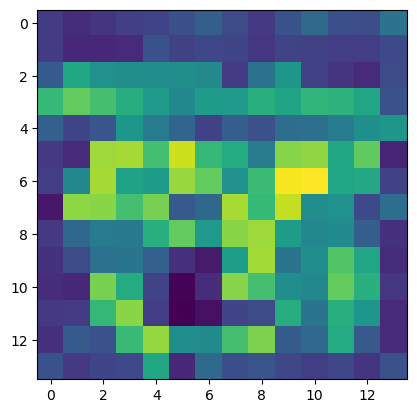

In [8]:
size = int(np.sqrt(shap_values.shape[1]))
plt.imshow(shap_values[0].reshape(size, size).cpu().numpy(), cmap="viridis")
shap_values[0].min().item(), shap_values[0].max().item()

tensor(-0.0074) tensor(0.0205)


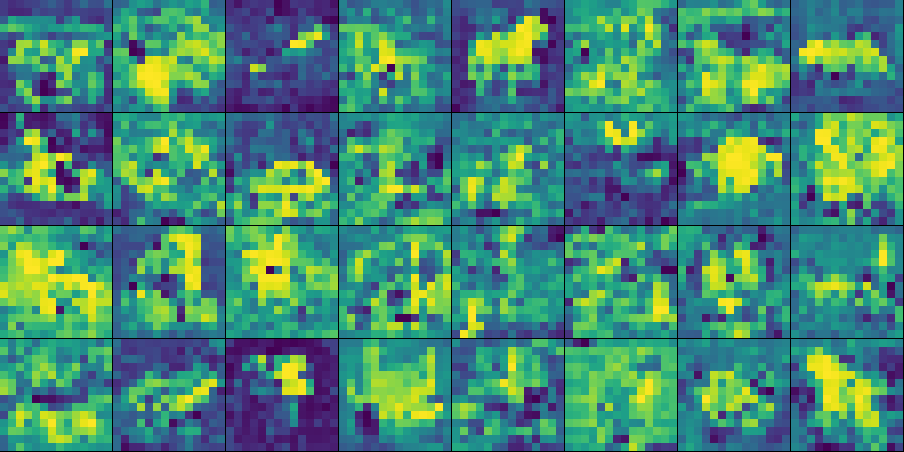

In [9]:
from vit_shapley.CIFAR_10_Dataset import _tensor_to_image, _make_image_grid
import PIL.Image

def get_heatmaps(values: torch.Tensor, images_shape: tuple[int, int, int, int], vmin: float = None, vmax: float = None) -> list[PIL.Image.Image]:
    """
    Args:
    - values: (B, num_players)
    - images_shape: (B, C, H, W)
    """
    B, num_players = shap_values.shape
    _B, C, H, W = images_shape
    assert B == _B and C == 3, f"Shape mismatch {shap_values.shape=}, {images_shape=}"
    print(values.min(), values.max())

    mask_H = int(np.round(np.sqrt(num_players)))
    mask_W = mask_H
    assert mask_H * mask_W == num_players, f"{num_players=}, expected a square number."
    values = values.view(B, mask_H, mask_W)

    # Upscale masks to image size.
    h_repeats, w_repeats = int(np.ceil(H / mask_H)), int(np.ceil(W / mask_W))
    values = values.repeat_interleave(h_repeats, dim=1).repeat_interleave(w_repeats, dim=2)
    values = values[:, :H, :W]

    if vmin is None:
        # vmin = values.min()
        vmin = values.min(dim=2, keepdim=True)[0].min(dim=1, keepdim=True)[0]
    if vmax is None:
        # vmax = values.max()
        vmax = values.max(dim=2, keepdim=True)[0].max(dim=1, keepdim=True)[0]
    values = (values - vmin) / (vmax - vmin + 1e-8)  # Normalize to [0, 1]

    color_map = plt.get_cmap('viridis')
    values = color_map(values)  # (B, H, W, 4)
    values = values[:, :, :, :3]  # Remove alpha channel
    values = torch.tensor(values).permute(0, 3, 1, 2)  # (B, C, H, W)

    # values = values.unsqueeze(dim=1).expand(-1, 3, -1, -1)  # Add C dimension
    # Masks now have shape (B, 1, H, W)

    return [_tensor_to_image(v, scale=0.5, mean=0, std=1) for v in values]

heatmap_grid = _make_image_grid(get_heatmaps(shap_values, images.shape))
heatmap_grid

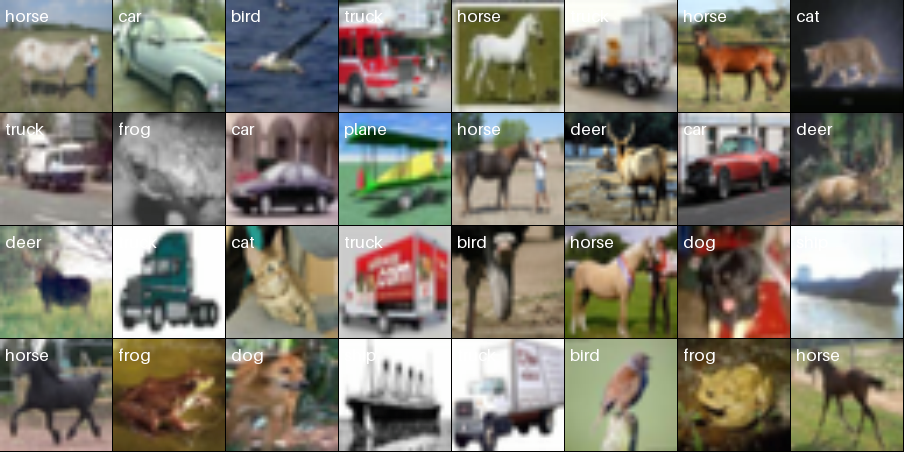

In [10]:
image_grid = CIFAR_10_Dataset.to_image_grid(images, labels, scale=0.5)
image_grid

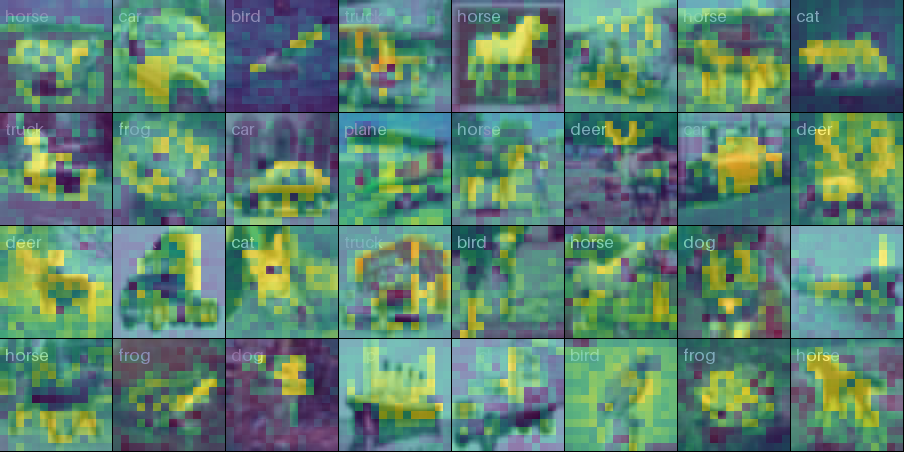

In [11]:
PIL.Image.blend(image_grid, heatmap_grid, alpha=0.6)

# Test best/worst/closest/furthest feature masking

In [12]:
quick_test_masked(surrogate, explainer, datamodule.test_dataloader())

100%|██████████| 313/313 [00:54<00:00,  5.78it/s, Masked-best-accuracy: 63.47%, Masked-worst-accuracy: 97.21%]


(63.468450479233226, 97.21445686900958)

In [13]:
from typing import Literal

def test_masked(surrogate: torch.nn.Module, dataloader: torch.utils.data.DataLoader, explainer: torch.nn.Module, players_to_mask: Literal["best", "worst", "random", "central", "peripheral"], device="cuda") -> None:
    results = []
    masked_percentages = []
    explainer.eval()
    surrogate.eval()
    with torch.no_grad():
        explainer.to(device)
        surrogate.to(device)
        correct, total = 0, 0
        with tqdm(dataloader, desc=players_to_mask) as dataloader_progress:
            for batch in dataloader_progress:
                images, masks, targets = batch['images'], batch['masks'], batch['labels']
                images, masks, targets = images.to(device), masks.to(device), targets.to(device)
                shap_values = explainer(images) if (players_to_mask in ["best", "worst"]) else None
                masks = remake_masks(images, masks, targets, players_to_mask, explainer.num_players, shap_values).to(device)
                images, masks, targets = apply_masks_to_batch(images, masks, targets)

                logits = surrogate(images)
                _, predicted = logits.max(dim=1)
                total += targets.shape[0]
                correct += predicted.eq(targets).sum().item()
                results.extend(predicted.eq(targets).cpu().numpy())
                masked_percentages.extend((1 - masks.float()).mean(dim=1).cpu().numpy() * 100)
                dataloader_progress.set_postfix_str(f'Accuracy: {100.0 * correct / total:.2f}%')
    return pd.DataFrame({'result': results, 'masked %': masked_percentages})

all_results = {}

In [19]:
import IPython.display
import ipywidgets

def plot(all_results: dict[str, pd.DataFrame], bucket_size: float = 100 / 14) -> None:
    # Smooth the plot by rounding 'masked %' to the nearest multiple of bucket_size.
    plot_results = deepcopy(all_results)
    for k, df in plot_results.items():
       df['masked %'] = df['masked %'].div(bucket_size).round().astype(int).mul(bucket_size)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    for i, ax in enumerate(axs):
        for k, df in plot_results.items():
            ax.errorbar(
                x=list(df.groupby('masked %').groups.keys()),
                y=df.groupby('masked %').mean()["result"].to_list(),
                yerr=df.groupby('masked %').sem()["result"].mul(3).to_list(),
                label=k
            )
        ax.plot([0, 100], [0.97, 0.97], color='black', linestyle='dashed', linewidth=0.7, label='97%')
        ax.legend()
        ax.set_xlabel('masked %')
        ax.set_ylabel('accuracy')
        if i == 0:
            ax.set_xlim(0, 100)
            ax.set_ylim(0.4, 1)
        else:
            ax.set_xlim(0, 20)
            ax.set_ylim(0.9, 1)
    plt.show()

# Make a sub-output for updating the plot live.
plot_output = ipywidgets.Output()
IPython.display.display(plot_output)

with tqdm(range(2), desc="repeats") as repeats:
    for repeat in repeats:
        for players_to_mask in ["best", "worst", "central", "peripheral", "random"]:
            # Update plot
            plot_output.clear_output(wait=False)
            with plot_output:
                plot(all_results)
            # Test and update results
            df = test_masked(surrogate, datamodule.test_dataloader(), explainer, players_to_mask)
            if players_to_mask not in all_results:
                all_results[players_to_mask] = df
            else:
                all_results[players_to_mask] = pd.concat([all_results[players_to_mask], df])

# Update plot
plot_output.clear_output(wait=True)
with plot_output:
    plot(all_results)

Output()

repeats:   0%|          | 0/2 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]